In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import evofr as ef
import matplotlib.pyplot as plt

In [2]:
# Getting data
raw_seq = pd.read_csv("../data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [3]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)

In [5]:
# Defining inference method
inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=100)

In [6]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

Text(0, 0.5, 'loss')

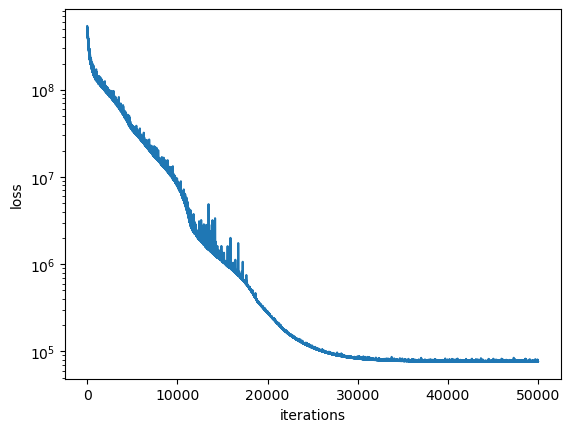

In [7]:
plt.plot(posterior.samples["losses"])
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")

In [8]:
ga = samples["ga"]

In [9]:
ga.shape

(100, 184)

In [9]:
type(ga)

jaxlib.xla_extension.DeviceArray

In [10]:
posterior.data.var_names[:10]

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.1.10',
 'BA.1.1.14',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.15']

In [11]:
ga_df = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)
ga_df.head(10)

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.5950956,1.6061066,1.5850044
1,USA,BA.1,0.6462755,0.6489429,0.644454
2,USA,BA.1.1,0.6718935,0.6737284,0.67022383
3,USA,BA.1.1.1,0.6784698,0.69876975,0.65971243
4,USA,BA.1.1.10,0.74011064,0.754721,0.72983587
5,USA,BA.1.1.14,0.6896542,0.7056107,0.6739731
6,USA,BA.1.1.16,0.70974934,0.72350246,0.69610196
7,USA,BA.1.1.18,0.6357476,0.6407994,0.63167816
8,USA,BA.1.1.2,0.6071195,0.62646276,0.5860163
9,USA,BA.1.15,0.62820584,0.63341564,0.62365097


In [12]:
ga_df.to_csv('growth_advantages.tsv', sep="\t")

In [16]:
def get_growth_advantage_delta(samples, data, ps, name, rel_to="other"):
    # Unpack variant info
    var_names = data.var_names
    par_names = [data.parent_map[v] for v in var_names]

    # Get posterior samples
    ga = jnp.array(jnp.exp(samples["delta"]))
    N_variant = ga.shape[-1]

    # Loop over ga and make relative rel_to
    for i, s in enumerate(var_names):
        if s == rel_to:
            ga = jnp.divide(ga, ga[:, i][:, None])

    #ga = jnp.divide(ga, ga[:, var_names.index(rel_to)][:, None])

    # Compute medians and quantiles
    meds = jnp.median(ga, axis=0)
    gas = []
    for i, p in enumerate(ps):
        up = 0.5 + p / 2
        lp = 0.5 - p / 2
        gas.append(jnp.quantile(ga, jnp.array([lp, up]), axis=0).T)

    # Make empty dictionary
    v_dict = dict()
    v_dict["location"] = []
    v_dict["variant"] = []
    v_dict["parent"] = []
    v_dict["median_ga_delta"] = []

    for p in ps:
        v_dict[f"ga_delta_upper_{round(p * 100)}"] = []
        v_dict[f"ga_delta_lower_{round(p * 100)}"] = []

    for variant in range(N_variant):
        if var_names[variant] != rel_to:
            v_dict["location"].append(name)
            v_dict["variant"].append(var_names[variant])
            v_dict["parent"].append(par_names[variant])
            v_dict["median_ga_delta"].append(meds[variant])
            for i, p in enumerate(ps):
                v_dict[f"ga_delta_upper_{round(p * 100)}"].append(gas[i][variant, 1])
                v_dict[f"ga_delta_lower_{round(p * 100)}"].append(gas[i][variant, 0])

    return v_dict

In [17]:
ga_delta_df = pd.DataFrame(
    get_growth_advantage_delta(samples, variant_frequencies, [0.8], "USA", rel_to="BA.2")
)
ga_delta_df.head(10)

KeyError: 'BE.5'

In [14]:
ga_delta_df.to_csv('growth_advantages_delta.tsv', sep="\t")

NameError: name 'ga_delta_df' is not defined